In [27]:
# --- Step 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers

In [28]:
# --- Step 2. Load Dataset ---
df = pd.read_csv("/content/drive/MyDrive/Farmseasy/weatherHistory.csv")

In [29]:
# --- Step 3. Basic Info ---
display(df.head())
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Shape: (96453, 12)

Columns:
 Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')

Missing Values:
 Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

Data Types:
 Formatted Date               object
Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (

In [30]:
# --- Step 4. Convert Date and Clean ---
df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], utc=True)
df = df.sort_values("Formatted Date")
df = df.set_index("Formatted Date")

# Drop unneeded columns
df = df.drop(columns=["Summary", "Daily Summary"], errors="ignore")

# Fill or encode missing precipitation types
df["Precip Type"] = df["Precip Type"].fillna("rain")
df["Precip Type"] = df["Precip Type"].map({"rain": 0, "snow": 1})

,count,mean,std,min,25%,50%,75%,max
Precip Type,96453.0,0.111059,0.314207,0.000000,0.000000,0.0000,0.000000,1.000000
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


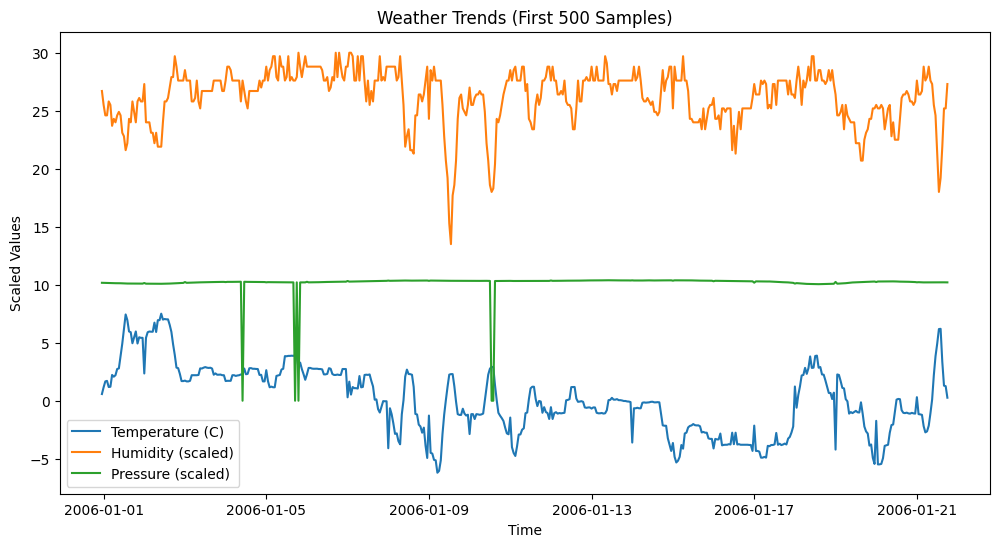

In [31]:
# --- Step 5. Exploratory Data Analysis (EDA) ---

# Quick statistical summary
display(df.describe().T)

# Plot temperature, humidity, pressure trends
plt.figure(figsize=(12,6))
plt.plot(df.index[:500], df["Temperature (C)"][:500], label="Temperature (C)")
plt.plot(df.index[:500], df["Humidity"][:500]*30, label="Humidity (scaled)")
plt.plot(df.index[:500], df["Pressure (millibars)"][:500]/100, label="Pressure (scaled)")
plt.title("Weather Trends (First 500 Samples)")
plt.xlabel("Time")
plt.ylabel("Scaled Values")
plt.legend()
plt.show()

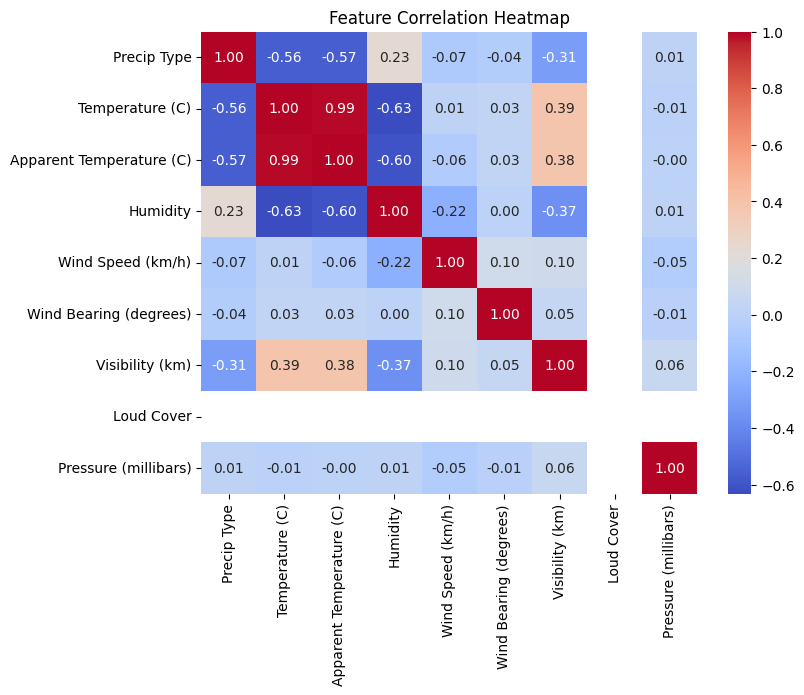

In [32]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [33]:
# --- Step 6. Feature Selection ---
features = ["Temperature (C)", "Humidity", "Pressure (millibars)"]
df = df[features]

In [34]:
# --- Step 7. Normalization ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)

In [35]:
# --- Step 8. Sequence Generation ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, :3])  # predicting first 3: Temp, Humidity, Pressure
    return np.array(X), np.array(y)

SEQ_LEN = 24  # past 24 hours
X, y = create_sequences(scaled_data, SEQ_LEN)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (96429, 24, 3) y shape: (96429, 3)


In [36]:
# --- Step 9. Train-Test Split (80/20 chronological) ---
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [37]:
# --- Step 10. Build LSTM Model ---
model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, X.shape[2])),
    layers.LSTM(32),
    layers.Dense(3)  # output for Temp, Humidity, Pressure
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,923 (116.89 KB)

 Trainable params: 29,923 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# --- Step 11. Train Model ---
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0220 - mae: 0.0758 - val_loss: 0.0030 - val_mae: 0.0257
Epoch 2/30
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0046 - mae: 0.0313 - val_loss: 0.0028 - val_mae: 0.0230
Epoch 3/30
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0044 - mae: 0.0295 - val_loss: 0.0029 - val_mae: 0.0252
Epoch 4/30
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0043 - mae: 0.0286 - val_loss: 0.0030 - val_mae: 0.0277
Epoch 5/30
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0043 - mae: 0.0278 - val_loss: 0.0029 - val_mae: 0.0263
Epoch 6/30
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0041 - mae: 0.0270 - val_loss: 0.0028 - val_mae: 0.0265
Epoch 7/30
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0035 - mae: 0.0258 - val_loss: 0.0027 - val_mae: 0.0251
Epoch 8/30
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0034 - mae: 0.0253 - val_loss: 0.0027 - val_mae: 0.0249
Epoch 9/30
1929/1929 ━━━━━━━━━━━

In [40]:
# --- Step 12. Evaluate Model ---
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(np.concatenate((y_test, np.zeros((y_test.shape[0], scaler.n_features_in_ - y_test.shape[1]))), axis=1))[:, :3]
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], scaler.n_features_in_ - y_pred.shape[1]))), axis=1))[:, :3]

# Metrics
for i, col in enumerate(["Temperature (C)", "Humidity", "Pressure (millibars)"]):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])
    print(f"\n📊 {col} → RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📊 Temperature (C) → RMSE: 0.929, MAE: 0.681, R²: 0.990

📊 Humidity → RMSE: 0.046, MAE: 0.033, R²: 0.941

📊 Pressure (millibars) → RMSE: 63.974, MAE: 29.192, R²: 0.787


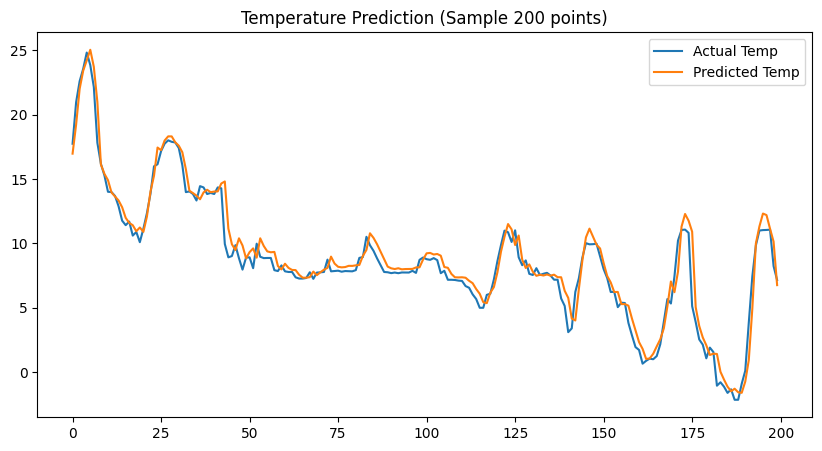

In [41]:
# --- Step 13. Visualize Predictions ---
plt.figure(figsize=(10,5))
plt.plot(y_test_inv[:200,0], label="Actual Temp")
plt.plot(y_pred_inv[:200,0], label="Predicted Temp")
plt.title("Temperature Prediction (Sample 200 points)")
plt.legend()
plt.show()

In [42]:
# --- Step 14. Save Model ---
model.save("multi_output_weather_lstm.keras")
print("✅ Model saved successfully!")

✅ Model saved successfully!
